In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933}

In [3]:
for job in project.find_jobs({"doc.npt_equilibrated": True}):
    print(job.sp.kT)

2.6
2.4
3.8
1.8
2.6
1.0
1.2
2.2
3.8
1.6
2.0
1.6
1.4
1.2
3.6
2.0
2.2
1.0


In [16]:
print(len([j for j in project if j.doc.npt_equilibrated]))
print(len([j for j in project if not j.doc.npt_equilibrated]))

19
11


/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/38745c2bc3616fffe8fbb031a8d74f99 3.2
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/d4f337da0a7ee79a1778c858471aa917 3.2


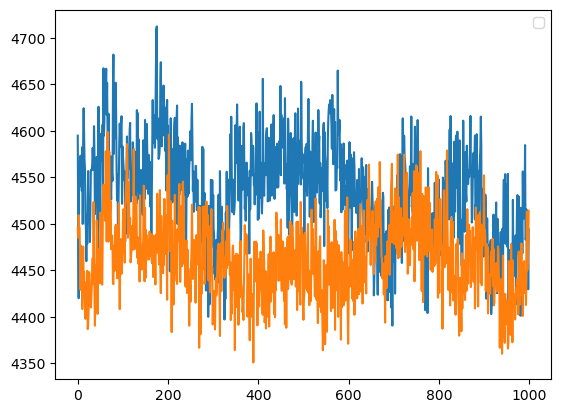

In [17]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"pressure": 0.0013933,
    "kT": 3.2,
    "doc.npt_equilibrated": False
}
for job in project.find_jobs(filter=job_filter):
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    plt.plot(vol[:])
    #plt.plot(temp[3950:])
    #plt.plot(pe[-1000:], label=job.sp.kT)
    print(job.path, job.sp.kT)

plt.legend()

# Check for NPT Equilibration:

In [5]:
for job in project.find_jobs(filter={"doc.npt_equilibrated": False}):
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    if job.doc.npt_runs == 1:
        sample_idx = len(vol)//2
    else:
        sample_idx = 0
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.20, threshold_neff=200)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.20, threshold_neff=200)[0]
    print(job.sp.kT, vol_eq, pe_eq)
    if all([vol_eq, pe_eq]):
        print("equilibrated")
        job.doc.npt_equilibrated = True
    print()

3.0 False True

3.4 False False

3.2 False False

3.0 False True

1.8 True True
equilibrated

2.8 False True

2.4 False True

2.8 False True

1.4 False True

3.4 False True

3.6 False False

3.2 False True



# Sample Volume:

In [18]:
for job in project.find_jobs(filter={"doc.npt_equilibrated": True, "doc.volume_sampled": False}):
    print(job.id, job.sp.kT)
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    if job.doc.npt_runs == 1:
        sample_idx = len(vol)//2
    else:
        sample_idx = 0
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
            vol[sample_idx:], threshold_fraction=0.20, threshold_neff=200
        )
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

825d861b4c33b56fe804d6f0791b175f 1.8


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


1.0 1.236013477101961
1.2 1.2304721694406466
1.4 1.2158069239627844
1.6 1.207653555171011
1.8 1.1962640076485112
2.0 1.1813658360974637
2.2 1.1854153750062457
2.6 1.1415873264920748
3.6 0.9645896141778199
3.8 0.9063878169062567


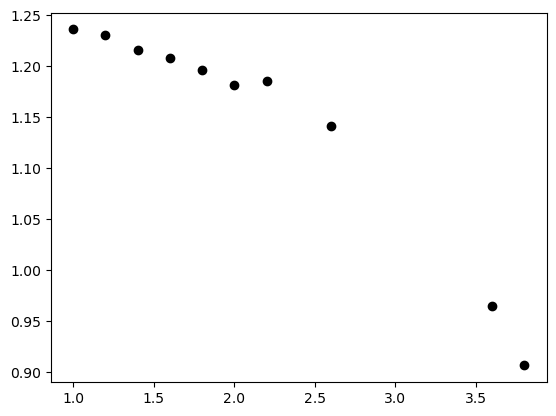

In [21]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "doc.volume_sampled": True, "sigma_scale": 1.0}
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    print(kT, job.doc.avg_density)
    #print(kT, job.path)
    plt.plot(kT, job.doc.avg_density, "ko")
    #plt.vlines(x=1.67, ymin=0.68, ymax=0.72, ls="--", color="red")

In [26]:
for job in project.find_jobs({"doc.volume_sampled": True}):
    if not job.isfile("trajectory-nvt0.gsd"):
        print(job.sp.kT)

2.4
1.8
2.6
2.2
2.0
1.6
2.2
